In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will try to predict churn using churn [dataset](https://www.kaggle.com/competitions/playground-series-s4e1/overview) from kaggle

# Reading data

In [2]:
data = pd.read_csv('./data/train.csv', index_col='id')
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
data.shape

(165034, 13)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [5]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [6]:
data.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

I think `CustomerId` and `Surname` columns are irrelevant, so I'll drop them

In [7]:
data = data.drop(['CustomerId', 'Surname'], axis=1)

In [8]:
target_col = 'Exited'
num_cols = [col for col in data.columns if data[col].dtype in (np.int64, np.float64) and col != target_col]
cat_cols = [col for col in data.columns if col not in num_cols and col != target_col]

## EDA

Lets look at distribution of numeric variables

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>]], dtype=object)

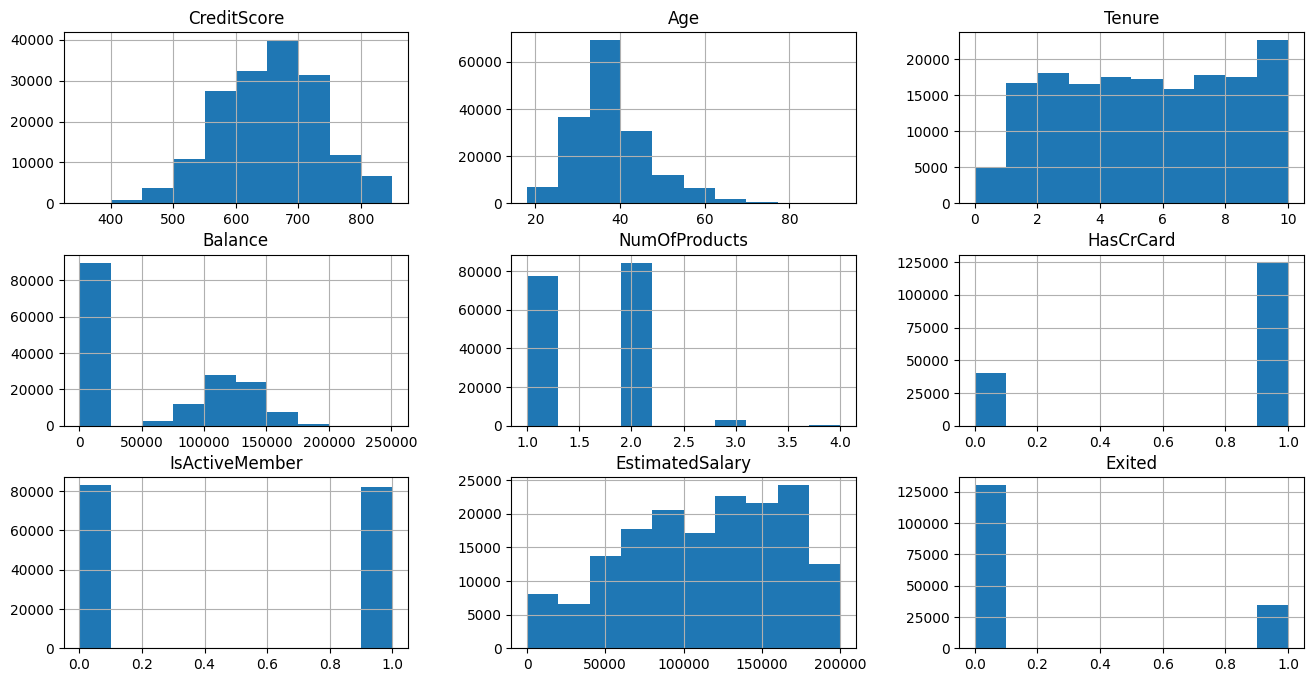

In [9]:
data.hist(figsize=(16, 8))

Now lets look at categorial data

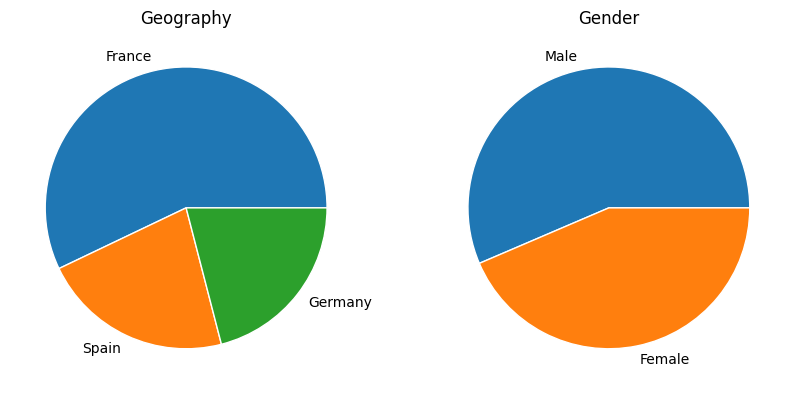

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

for i, ax in enumerate(axes):
    data_dist = data[cat_cols[i]].value_counts()
    ax.pie(data_dist, wedgeprops={"linewidth": 1, "edgecolor": "white"}, labels=data_dist.index.values)
    ax.set_title(cat_cols[i])

We can see outliers in `Tenure` distribution and slight imbalance in `Gender`. I think it may show insights for data so we will keep it that way. Also our target varibale is imbalanced, which is not good.

Lets look at some variables by target

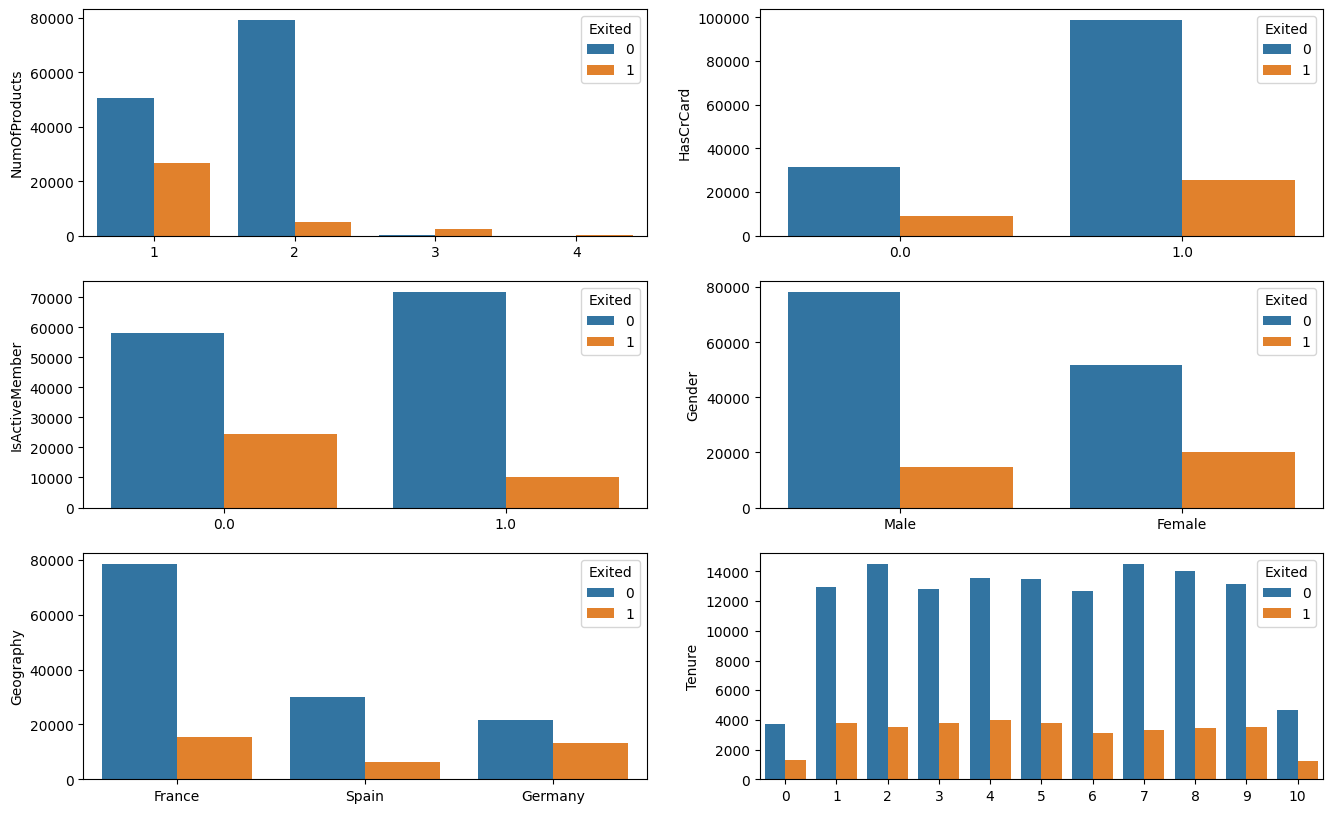

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
axes = axes.flatten()
discrete_cols = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Gender', 'Geography', 'Tenure']

for i, col in enumerate(discrete_cols):
    sns.countplot(data, x=col, hue=target_col, ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)

    


We can see that there is less churn among active members and credit card holders. Also with 2 or more products there is significantly less churn.

Finally, lets look at correlation between variables.

<Axes: >

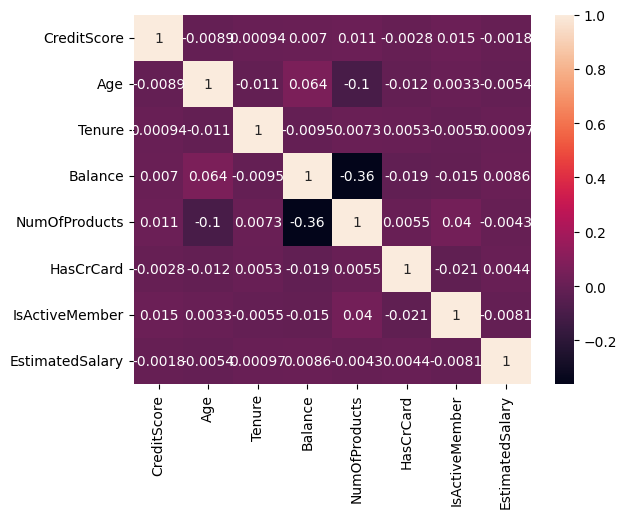

In [12]:
sns.heatmap(data[num_cols].corr(), annot=True)

# Data Cleaning and preprocessing

In [13]:
data.isna().sum().sum()

0

Surprisingly, we don't have missing values.

Lets convert gender column's type into integer since it has only to 2 values.

In [14]:
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [15]:
num_cols.append('Gender')
cat_cols.remove('Gender')
num_cols, cat_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary',
  'Gender'],
 ['Geography'])

Now lets split our data and apply one-hot encoding and scaling

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X, y = data.drop('Exited', axis=1), data['Exited']


cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='error'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_cols), ('num', num_transformer, num_cols)])
preprocessor.fit(X)

X_transformed = pd.DataFrame(preprocessor.transform(X), columns=preprocessor.get_feature_names_out())
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2)

# Model selection

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
pipeline = Pipeline([("classifier", LogisticRegression())])
param_grid = {"classifier": [LogisticRegression(), KNeighborsClassifier(),
                             RandomForestClassifier()]}
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="roc_auc",
    return_train_score=True,
)
grid_search.fit(X_transformed, y)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier': [LogisticRegression(),
                                        KNeighborsClassifier(),
                                        RandomForestClassifier()]},
             return_train_score=True, scoring='roc_auc')

In [19]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.8734773479708434
Pipeline(steps=[('classifier', RandomForestClassifier())])


[LightGBM] [Info] Number of positive: 27920, number of negative: 104107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211472 -> initscore=-1.316076
[LightGBM] [Info] Start training from score -1.316076


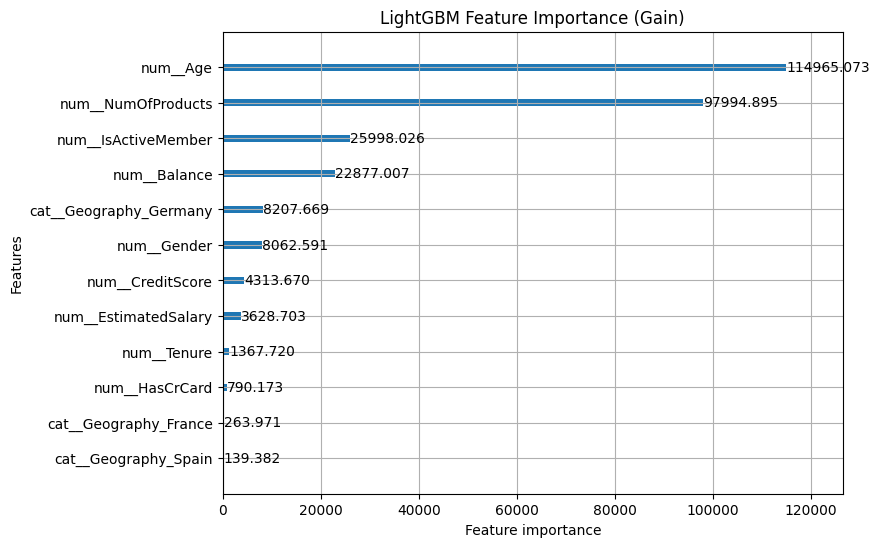

In [20]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(8,6), max_num_features=12,
                    title="LightGBM Feature Importance (Gain)")
plt.show()

In [38]:
y_pred = lgb_model.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:, 1]))

0.8879884283458347


In [39]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=250,
    learning_rate=0.10,
    colsample_bytree=0.70,
    max_depth=3,
    n_jobs=4
)

xgb_model.fit(
    X_train, y_train,
    verbose=False
)

y_pred = xgb_model.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:, 1]))

0.8880961161292666


In [42]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
0,668,France,1,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,1,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,1,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,1,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,1,33.0,5,0.00,2,1.0,1.0,15068.83
...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,0,33.0,2,0.00,1,1.0,1.0,131834.75
165030,792,France,1,35.0,3,0.00,1,0.0,0.0,131834.45
165031,565,France,1,31.0,5,0.00,1,1.0,1.0,127429.56


In [31]:
scaler = StandardScaler()
scaler.fit(X[num_cols])
X_scaled = pd.DataFrame(scaler.transform(X[num_cols]), columns = scaler.get_feature_names_out())
X_scaled = pd.concat([X[cat_cols], X[num_cols]], axis=1)

In [28]:
from catboost import cv, Pool

params = {
    'loss_function': 'Logloss',
    'iterations': 500,
    'custom_loss': 'AUC',
    'random_seed': 42,
    'learning_rate': 0.01
}

cv_results = cv(
    params=params,
    pool=Pool(X_scaled, label=y, cat_features=cat_cols),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True, 
    verbose=False,
    return_models=True
)

print(cv_results[0])

Training on fold [0/5]

bestTest = 0.3239131316
bestIteration = 499

Training on fold [1/5]

bestTest = 0.3186551725
bestIteration = 499

Training on fold [2/5]

bestTest = 0.3208626823
bestIteration = 499

Training on fold [3/5]

bestTest = 0.3215523138
bestIteration = 499

Training on fold [4/5]

bestTest = 0.3227770568
bestIteration = 499

     iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.683349          0.000030            0.683347   
1             1           0.674256          0.000257            0.674252   
2             2           0.665133          0.000202            0.665122   
3             3           0.656599          0.000250            0.656585   
4             4           0.647937          0.000377            0.647905   
..          ...                ...               ...                 ...   
495         495           0.321583          0.001993            0.320101   
496         496           0.321576          0.0

Lightgbm model will be best choice.

In [44]:
import pickle  

with open("./models/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f, -1)
lgb_model.booster_.save_model("./models/lgbm_model.txt")